In [ ]:
%matplotlib inline
# %matplotlib notebook
# uncomment for interactive plots

from functools import partial
import random

import jax
import jax.numpy as np
from jax import grad, jit, vmap, jacfwd
import jax.random

from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import torchvision

plt.rc('axes', labelsize="x-large")

In [ ]:
lim = 2

theta_xs = np.linspace(-lim, lim, 51)
thetas = np.array(np.meshgrid(theta_xs, theta_xs))
thetas = np.moveaxis(thetas, 0, -1)

precise_theta_xs = np.linspace(-lim, lim, 201)
precise_thetas = np.array(np.meshgrid(precise_theta_xs, precise_theta_xs))
precise_thetas = np.moveaxis(precise_thetas, 0, -1)

In [ ]:
def plot_surface(surf_thetas, surf_vals,
                 cmap=cm.coolwarm, lw=0., antialiased=True, alpha=0.5,
                 lim=lim, surf_lims=[0, 10], zlabel='', ax=None):
    
    surf_vals = np.squeeze(surf_vals)
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca(projection='3d')
        
    ax.plot_surface(surf_thetas[:, :, 0], surf_thetas[:, :, 1], surf_vals,
                    cmap=cm.coolwarm, lw=0., antialiased=True, alpha=0.5)
    
    ax.set_zlabel(zlabel, rotation=90);
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim]);
    ax.set_zlim(surf_lims);
    
    return ax

In [ ]:
def plot_gradient_field(thetas, Ls, gradfield, step=4, ax=None, **quiver_kwargs):
    
    Ls = np.squeeze(Ls)
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca(projection='3d')
    
    thetas = thetas[::step, ::step, ...]
    Ls = Ls[::step, ::step]
    gradfield = gradfield[::step, ::step, ...]
    
    ax.quiver(thetas[..., 0], thetas[..., 1], Ls,
              -1 * gradfield[..., 0], -1 * gradfield[..., 1], 0.1,
              normalize=False, color="gray", lw=1, **quiver_kwargs)
    
    return ax

In [ ]:
def plot_critical_regions(thetas, filter_surface, eps=1e-1, ax=None, **scatter_kwargs):
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca(projection='3d')
        
    low_values = filter_by(thetas, filter_surface < eps)

    ax.scatter(*low_values, **scatter_kwargs)
    
    return ax


def filter_by(tensor, matrix):
    return np.array([tensor[..., ii][matrix]
                     for ii in range(tensor.shape[-1])])

In [ ]:
def prep_for_plot(batched_gds, loss):
    ndim = batched_gds.ndim
    if ndim == 4:
        gd_xs, gd_ys, gd_zs = to_trajs(batched_gds, L)
        gd_3d_trajs = to_3d_trajs(gd_xs, gd_ys, gd_zs)
    elif ndim == 3:
        gd_3d_trajs = to_3d_trajs(batched_gds[..., 0], batched_gds[..., 1], L(batched_gds, [1.]))
    else:
        raise ValueError(f"batched_gds must have 3<=ndim<=4, was {ndim}")
        
    return gd_3d_trajs


def to_matplotlib_shape_gds(gds, skip=2):
    return np.reshape(gds[:, ::skip, ::skip], (gds.shape[0], -1), order="F")


def to_trajs(simultaneous_gds, L):

    losses = L(simultaneous_gds, np.array([1.]))
        
    gd_xs = to_matplotlib_shape_gds(simultaneous_gds[..., 0])

    gd_ys = to_matplotlib_shape_gds(simultaneous_gds[..., 1])

    gd_zs = to_matplotlib_shape_gds(losses)
    
    return gd_xs, gd_ys, gd_zs


def to_3d_trajs(gd_xs, gd_ys, gd_zs):
    return np.stack([gd_xs.T, gd_ys.T, gd_zs.T], axis=-1)

In [ ]:
def plot_batched_gd(gd_trajs, surf_thetas, surf_losses, **lc3d_kwargs):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')

    lc = Line3DCollection(gd_trajs, **lc3d_kwargs)

    plot_surface(surf_thetas, surf_losses,
                 cmap=cm.coolwarm, lw=0., antialiased=True, alpha=0.5, ax=ax)

    ax.add_collection(lc)
    
    return ax

# Neural network optimization is complicated, and harder than it seems.

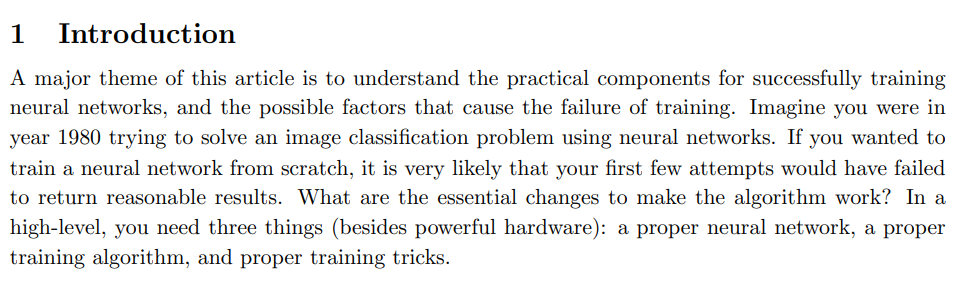

-- From [_Optimization for Deep Learning_](https://arxiv.org/abs/1912.08957) by Ruouyu Sun

# Test problems can drive understanding

> Basically, I and everyone I know who does math does the exact same thing.
Whenever they hear a conjecture, they compare it to two examples:
one that's well-behaved and simple and another that's pathological and counter-intuitive.
If the conjecture is true on both, then it's probably true.
If it's not, you've got yourself a counterexample.

-- Paraphrased from a Berkeley Math PhD

# Memorization tasks and adversarial examples make good pathological test examples.

## Memorization task: destroy all structure relating inputs to labels.

In [ ]:
mnist = torchvision.datasets.MNIST(root=".", train=True, download=True)

mnist.targets = random.sample(list(mnist.targets), len(mnist.targets))

Neural networks can still minimize the training loss (see [Zhang et al., 2016](https://arxiv.org/abs/1611.03530)).

# Today, we'll talk about a well-behaved and simple example I use: multiplying by one. 

**Definition**. A (fully-connected) _network_ $f$ is a function of _parameters_ $\theta$ and _inputs_ $x$
that alternates between matrix multiplication and function application:

$$
f(\theta; x) = \theta_K \sigma_K\left(\theta_{K-1} \sigma_{K-1}\left(\dots \sigma_{1}\left( \theta_{1} x\right)\dots\right)\right)
$$

where each $\theta_i$ is a matrix and $x$ is a vector.

**Definition**. An _autoencoder_ network $f$ is a network that compares its outputs to its inputs:

$$
l(\theta; x) = D\left(x, f(\theta; x)\right)
$$

where $D(x, x) = 0$. The function $l$ is the _loss function_.

## The class of autoencoders includes multiplying by one as a special case:

Let's choose all of our functions $\sigma_i$ to be the identity
(`def f(x): return x`),

$$
f\left(\theta; x\right) = \theta_K \theta_{K-1} \dots \theta_1 \theta_0 x
$$

This is a _linear network_, and linear networks are often used as a test case for theory on neural networks,
e.g. [Saxe, McClelland, and Ganguli, 2018](https://arxiv.org/abs/1810.10531).

Also, networks with ReLU are _piecewise linear_ on their inputs.

and let's also choose $x$ to be a vector of dimension 1,

$$
f\left(\theta; x\right) = \theta_K \cdot \theta_{K-1} \cdot \dots \theta_1 \cdot \theta_0 \cdot x
$$

In [JAX](https://github.com/google/jax)-style numpy,
that function looks like:

In [ ]:
@partial(np.vectorize, signature="(h),(d)->(d)")
def f(theta, x):
    return np.prod(theta, axis=0) * x

The `@partial` decorator and `np.vectorize` application allow this single Python function
to represent a clutch of semantically-related functions:
applying `f` on multiple values of `x` with the same `theta` (batch application),
applying `f` on multiple values of `theta` with the same `x` (model comparison/ensembling),
or applying `f` on multiples values of `x` and `theta` (model ensembling on batches).

And all of these implementations are fast!
This kind of expressive power is why lots of folks doing research on DNNs are excited about JAX.

# In this simple setting, we can see everything.

For visualization purposes, let's also choose $K$, the number of hidden layers, to be 1:

$$
f\left(\theta; x\right) = \theta_1 \cdot \theta_0 \cdot x
$$

## We can see the network's output as a function of the parameters.

This choice makes, say, the output on a specific input a scalar-valued function of two variables ($\theta_1$ and $\theta_0$),
as below:

In [ ]:
ax = plot_surface(thetas, f(thetas, [1]), zlabel=r"$f(\theta)$"); 

If we choose $D(x, y) = (x - y)^2$, the _squared error_, then the loss function $L$ on batches $X$ becomes

$$
L(\theta; X) = \frac{1}{n} \sum_{x \in X} \left(x - f\left(\theta, x\right)\right)^2
$$

or, in code:

In [ ]:
def squared_error(theta, x):
    return np.square(np.array(x) - f(theta, x))


def L(theta, x):
    return np.mean(squared_error(theta, x), axis=-1)

##  This loss is simple enough we can write it out explicitly

In particular,
we focus on a single datapoint and choose it to be $1$, for simplicity.

## 

$$
L(\theta; 1) = \left(1 - f\left(\theta; 1\right)\right)^2
$$

$$
= (1 - \theta_1 \theta_0)^2\\
$$

$$
= 1 + \theta_1^2\theta_0^2 - 2\theta_1\theta_0
$$

Moving forward, we'll take the data, $x$, to be fixed and equal to $1$
and vary the parameters only.

## and we can view the network's loss as a function of the parameters.

In [ ]:
Ls = L(thetas, [1])
plot_surface(thetas, Ls, zlabel=r"$L(\theta)$");

## We can similarly calculate the gradient by hand

$$
\nabla L(\theta) = -2 \cdot 
    \left[
        \begin{array}{c}
            \theta_2(1 - \theta_2\theta_1)\\
            \theta_1(1 - \theta_1\theta_2)
         \end{array}
    \right]
$$

This gradient is big when $\theta_2\theta_1$ is far from $1$ (try $5\cdot2 = 10$ and $-1\cdot10=-10$).

In Python, we rely on automatic differentiation:

In [ ]:
grad_L = np.vectorize(grad(L), signature="(h),(d)->(h)")

And that's exactly why a test case can be so useful!

Calling `grad` (or its equivalent in your favorite ML toolkit)
typically sets off a tidal wave of numerical operations.
The only way to build an intuition for what might happen
is to build an understanding of what happens in a simpler case.

## and view the gradient as a vector field.

In [ ]:
gradfield_L, precise_Ls = grad_L(precise_thetas, [1]), squared_error(precise_thetas, [1])

ax = plot_surface(thetas, Ls, zlabel=r"$L(\theta)$")
plot_gradient_field(precise_thetas, precise_Ls, gradfield_L, ax=ax, length=0.01);

## Gradient descent is used to optimize neural networks.

Gradient descent is based on the update rule

$$
\theta \leftarrow \theta - \eta \nabla L(\theta) 
$$

There are other algorithms, based on other update rules,
that are used to learn neural network parameters.
A fun extension of this code would apply Nesterov momentum or
an approximate second-order method like ADAM;
see [optimizers in FLAX](https://flax.readthedocs.io/en/latest/flax.optim.html#optimizers),
the neural network library for JAX.

or, in code:

In [ ]:
def gradient_descent(theta, grad_L, eta=0.1):
    return theta -eta * grad_L(theta, np.array([1.]))

batched_gradient_descent = np.vectorize(gradient_descent, excluded=(1, 2), signature="(h)->(h)")

**More fun with JAX 😊**

That last line there is setting it up so that we can train multiple networks _at the same time_! Nice.

In [ ]:
def run_batched_gd(num_steps, init_thetas, L, eta):

    simultaneous_gds = np.zeros([num_steps - 1] + list(init_thetas.shape))
    simultaneous_gds = np.concatenate([init_thetas[None, :], simultaneous_gds], axis=0)
    
    for ii in range(num_steps):
        simultaneous_gds = jax.ops.index_update(
            simultaneous_gds, jax.ops.index[ii + 1, :],
            batched_gradient_descent(simultaneous_gds[ii, :], L, eta))
        
    return simultaneous_gds

**Less fun with JAX 😭**

JAX has [🔪 sharp edges 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html):
it is functionally pure, so arrays are immutable.
That means we can't, e.g., assign values to entries directly.
Instead, we have to use a workaround.

There may be a smarter way to do this; I just wanted to show this pain point.

In [ ]:
simultaneous_gds = run_batched_gd(100, thetas, grad_L, 0.001)
gd_3d_trajs = prep_for_plot(simultaneous_gds, L)

## We can observe how gradient descent behaves directly, from many initial positions.

In [ ]:
ax = plot_batched_gd(gd_3d_trajs, thetas, Ls,
                     lw=2., antialiaseds=True, colors="k")

## Some positions clearly perform worse than others.

In [ ]:
fig, ax = plt.subplots()

ax.plot(gd_3d_trajs[::25, :, -1].T, color="k");
ax.set_ylabel(r"$L(\theta)$"); ax.set_xlabel("Iteration");

## Typical neural networks are initialized from random, normalized starting positions.

In [ ]:
key, subkey =  jax.random.split(jax.random.PRNGKey(117))

n_inits = 50
init_thetas = jax.random.normal(subkey, shape=(n_inits, 2))
init_thetas = init_thetas / np.linalg.norm(init_thetas, axis=1)[:, None]

**JAX and PRNG 🎲**

Randomness is also a bit tricky in JAX.
A random function is not pure --
it uses some source of entropy
to produce different outputs for the same inputs.

We have to be more explicit about when we're using entropy -- but this is a good thing!
It makes it much easier to make JAX code deterministic and therefore reproducible.

In [ ]:
random_init_gds = run_batched_gd(50, init_thetas, grad_L, 0.1)
random_init_3d_trajs = prep_for_plot(random_init_gds, L)

In [ ]:
ax = plot_batched_gd(random_init_3d_trajs, thetas, Ls,
                     lw=2., colors="k", antialiaseds=False)

## From these positions, training looks much better!

In [ ]:
fig, ax = plt.subplots()

ax.plot(random_init_3d_trajs[::3, :, -1].T, color="k");
ax.set_ylabel(r"$L(\theta)$"); ax.set_xlabel("Iteration");

And it looks more like what we see in the training of larger networks on more interesting problems:
some of the trajectories "plateau" before speeding up.

This is a problem for which a cyclical learning rate might be helpful:
a higher learning rate during the iterations in which gradient descent is stuck on the plateau
would allow it to escape more quickly.

## Due to the simplicity of the loss, we can calculate all possible solutions.



$$
\nabla L(\theta^\star)_1 = 0 = -2 \cdot 
            \theta^\star_2(1 - \theta^\star_2\theta^\star_1)
$$

$$
0 = \theta^\star_2(1 - \theta^\star_2\theta^\star_1)
$$

$$
\theta_1^\star \theta_2^\star = 1
$$

or, in code:

In [ ]:
def add_solutions_to_axis(ax):
    xmin, xmax = ax.get_xlim()
    
    pos_component = np.array([(x, 1. / x) for x in np.linspace(1. / xmax, xmax)])
    neg_component = -1 * pos_component
    ax.scatter(*pos_component.T, color="xkcd:chartreuse")
    ax.scatter(*neg_component.T, color="xkcd:chartreuse")
    
    return

## And we can then visualize that solution set.

In [ ]:
ax = plot_batched_gd(random_init_3d_trajs, thetas, Ls,
                     lw=2., colors="k", antialiaseds=False)
add_solutions_to_axis(ax);

These two sets of solutions represent two distinct ways of solving the problem:
by flipping the sign of the input and flipping it back, or by not doing so.

Notice that only one of these is close to a typical human solution to this problem!

These two solutions are separated by a barrier -- it's not that high,
but it's high enough to block gradient descent, even with noise.

From any one solution, another solution can be obtained easily:
just multiply one parameter by $a$ and the other by $1/a$.

## This picture of the solution sets for neural networks generalizes to more realistic settings.

- For ReLU networks, as demonstrated in [Freeman and Bruna, 2016](https://arxiv.org/abs/1611.01540),
the solutions have the same algebraic structure (in the infinitely-overparameterized regime).

- Solutions in different basins can have very different representations and performance, even though they are separated by only a small barrier (see [Garipov et al., 2018](https://arxiv.org/abs/1802.10026))

- I used a higher-dimensional version of the same problem to improve techniques for finding zero-gradient points of neural networks in [Frye et al., 2019](https://arxiv.org/abs/1901.10603).

# In general, use simple problems like this one to build your understanding.

Useful ideas and technologies are usually compositions of simpler pieces,
and those simpler pieces tend to admit base cases
that are particularly intuitive or easy to understand.

When you combine that with pathological counterexamples,
you've got a one-two punch for tackling difficult concepts!